In [2]:
import sys
import pymrio as pym
from pathlib import Path
import numpy as np
import pandas as pd
import pickle as pkl
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


def display_f(df):
    """Permet d'afficher un dataframe en entier (toutes les lignes, toutes les colonnes) (attention avec les gros dataframes du coup)"""
    with pd.option_context("display.max_colwidth", None), pd.option_context("display.max_rows", None), pd.option_context("display.max_columns", None):
        display(df)

# N_sec*N_reg,N_sec*N_reg matrix : fraction of product Z imported from region R
# over total usage of product Z in the mix of (sector,region)
def calc_SPC_local(mrio):
    Id = np.eye(len(mrio.get_sectors()))
    I_Sum = np.tile(Id, len(mrio.get_regions()))
    Z0_C = I_Sum.dot(mrio.Z)
    Z0_C = np.tile(Z0_C,(len(mrio.get_regions()),1))
    res = np.zeros(shape=mrio.Z.shape)
    return np.divide(mrio.Z,Z0_C, where=(Z0_C!=0))
    #return mrio.Z.div(np.tile(Z0_C,(len(mrio.get_regions()),1)))

#SPC_local.iloc[0,3]=0
#print(SPC_local)
# For a fixed regional production and given another region R', 
# its max SPC_local, that is, the product from R' most important
# for this regional production.
def calc_max_product_SPC_by_region(SPC_loc):
    return SPC_loc.groupby(level=0).max()

# Regional SPC ; RR,RR matrix : Dependance of one region
# to another
# Agregation is made by weighting each sector 
# by its importance in the overall production
# and then summing.
def calc_SPC_reg(mrio):
    SPC_loc = calc_SPC_local(mrio)
    max_prod_SPC_region = calc_max_product_SPC_by_region(SPC_loc)
    # fraction_of_prod = 
    # mrio.x.index.tolist()
    # importance of a regional specific production over overall prodution of the region.
    # i. e. sector fraction of GDP.
    fraction_of_total_prod = mrio.x / mrio.x.groupby('region').sum()
    SPC_reg = max_prod_SPC_region * np.tile(np.array(fraction_of_total_prod).flatten('F'),(len(mrio.get_regions()),1))
    SPC_reg_sum=SPC_reg.T.groupby('region').sum().T
    return SPC_reg_sum, SPC_loc

In [10]:
with open("../outputs/sample_30/OECD21-2018.pkl",'rb') as f:
    mriot = pkl.load(f)

EU_agg = pd.DataFrame(mriot.get_regions().to_list(),index=mriot.get_regions(),columns=['original region'])

EU_regs_exio = ["AT","BE","BG","CH","DE","DK","EE","ES","FI","FR","GB","GR","HR","HU","IE","IT","LT","LU","LV","MT","NL","NO","PL","PT","RO","SE","SI","SK"]
EU_regs = ["AUT","BEL","BGR","CHE","DEU","DNK","EST","ESP","FIN","FRA","GBR","GRC","HRV","HUN","IRL","ITA","LTU","LUX","LVA","MLT","NLD","NOR","POL","PRT","ROU","SWE","SVN","SVK"]

df_aggreg = pd.read_excel("../outputs/sectors_common_aggreg.ods", sheet_name="icio2021_to_common_aggreg", index_col=0)
#df_region = pd.read_excel("../../Code/Boario-Climada-Compound_Events/workflow/config/regions_common_aggreg.ods", sheet_name="icio2021_to_common_aggreg", index_col=0)
#df_region = df_region.reset_index()
EU_agg["new region"] = EU_agg["original region"]
#df_region.set_index("original region",inplace=True)
EU_agg.loc[EU_regs,"new region"] = "Europe"
mriot.rename_sectors(df_aggreg["new sector"].to_dict())
mriot.rename_regions(EU_agg["new region"].to_dict())

mriot.aggregate_duplicates()
mriot.calc_all()

In [11]:
SPC_reg_sum, SPC_local = calc_SPC_reg(mriot)

SPC_EU=pd.DataFrame(SPC_reg_sum['Europe'])

# Exemple : We see France is quite dependant from
# Russia, and want to know more.
# We can look into local SPC with 
CHN_ind=SPC_local.loc['CHN','Europe']

# Then we can filter to see relevant sectors and droping
# column and rows that are not interesting
#Russia_inf=Russia_inf[(Russia_inf > 0.1)].dropna(1,how='all')

In [12]:
SPC_EU.sort_values(by="Europe",ascending=False)

,Europe
region,
Europe,0.998911
ROW,0.169428
RUS,0.057341
CHN,0.033846
USA,0.031689
ZAF,0.026419
BRA,0.024702
CAN,0.019748
KAZ,0.015525


In [22]:
SPC_EU

,Europe
region,
ARG,0.005526
AUS,0.007023
BRA,0.024702
BRN,0.000007
CAN,0.019748
CHL,0.006305
CHN,0.033846
COL,0.001436
CRI,0.001264


In [52]:
row_value = SPC_EU.reset_index()[SPC_EU.reset_index()['region']=='ROW']['Europe'].values[0]

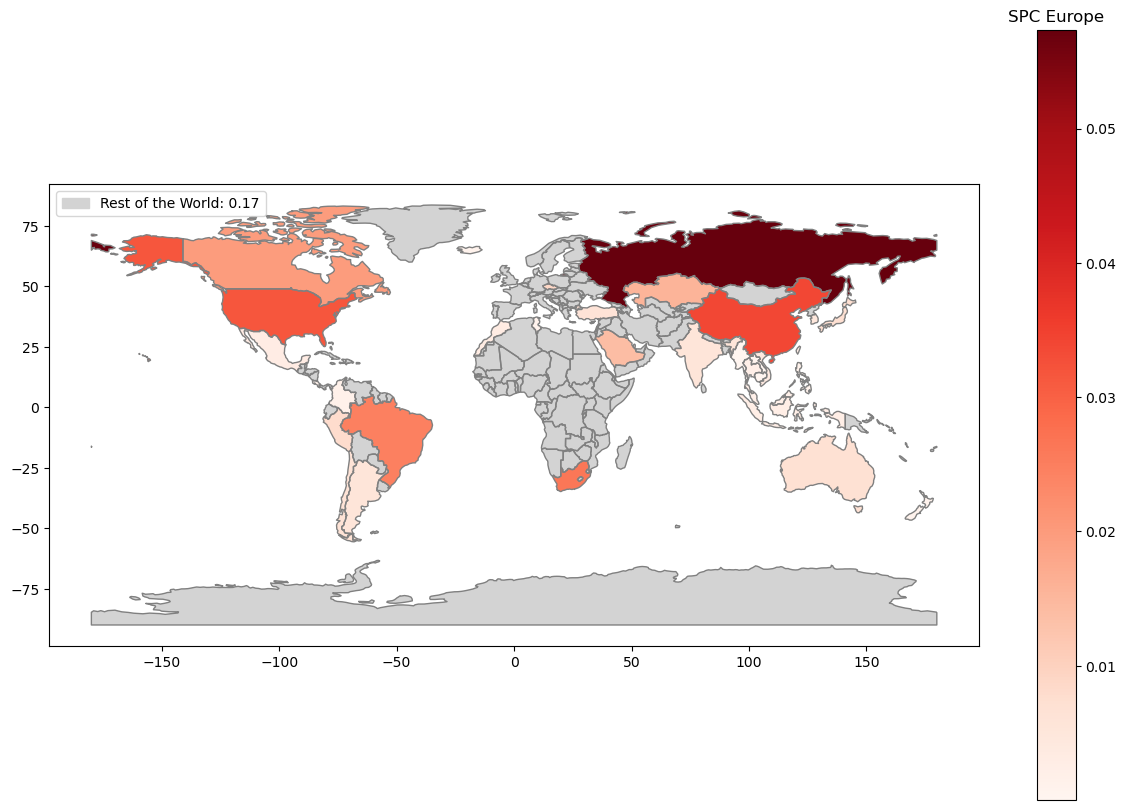

In [55]:
import geopandas as gpd
import matplotlib.pyplot as plt


# Read world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge data
merged = world.merge(SPC_EU, left_on='iso_a3', right_on='region', how='left')

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot entire world in gray
world.boundary.plot(ax=ax, linewidth=1, color='gray')
world.plot(ax=ax, color='lightgray')

# Overplot countries with data from SPC_EU
merged.dropna(subset=['Europe']).plot(column="Europe", ax=ax, legend=True, cmap='Reds')

# Get colorbar and add description
colorbar = ax.get_figure().get_axes()[1]
colorbar.set_title("SPC Europe")

# Create custom legend for ROW
row_patch = mpatches.Patch(color='lightgray', label=f'Rest of the World: { round(row_value,2)}')
ax.legend(handles=[row_patch], loc='upper left')